In [1]:
from sklearn.externals import joblib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

## Load model generated in previous notebook

In [2]:
dist_pickle = joblib.load( 'model.pkl' )

## Multi window sliding and false positve fix

/usr/local/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


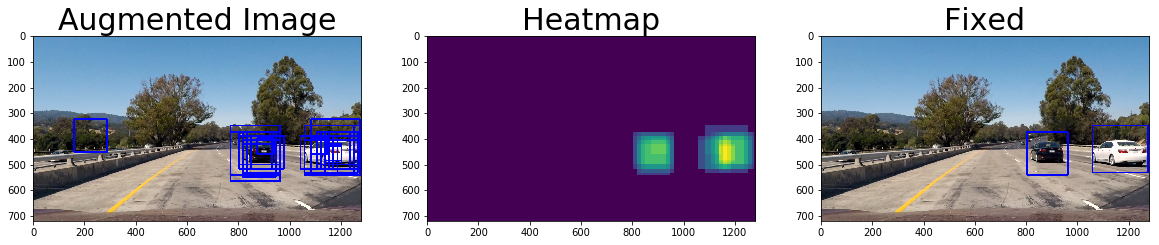

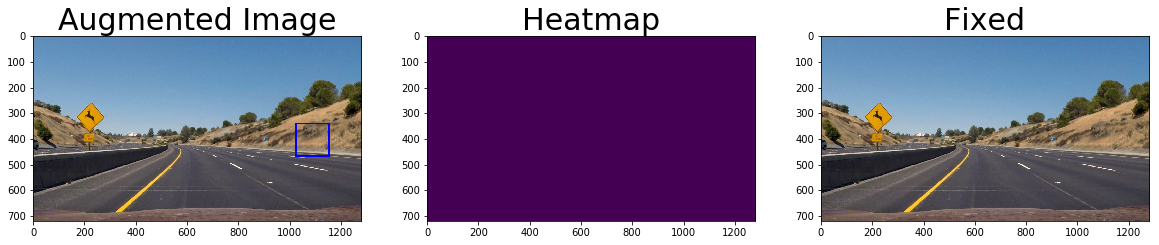

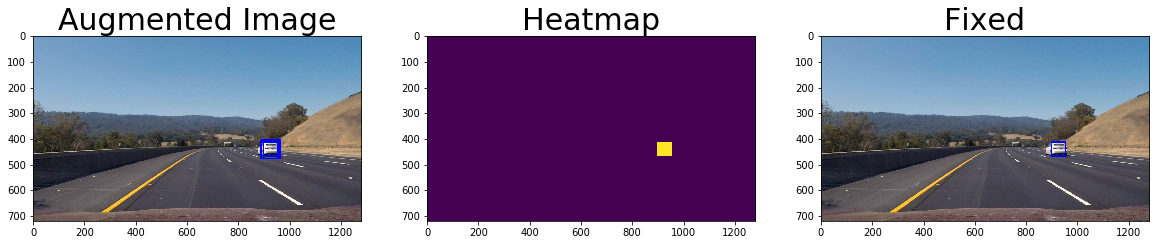

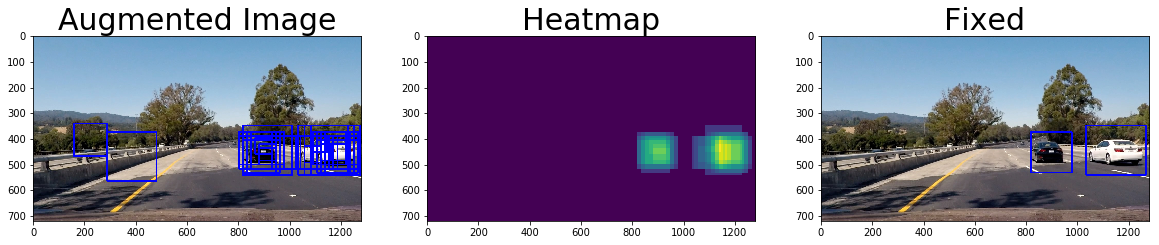

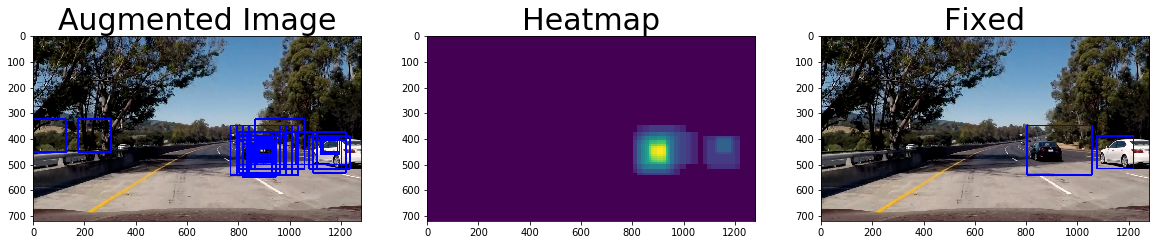

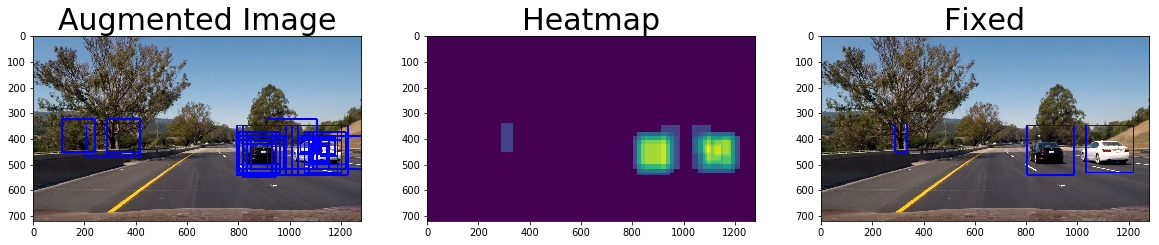

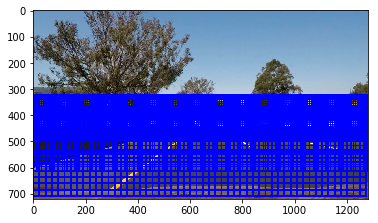

In [3]:
%matplotlib inline
import glob
from hog_subsample import find_cars 
from false_positives import add_heat, apply_threshold, draw_labeled_bboxes
import matplotlib.image as mpimg
from scipy.ndimage.measurements import label
from lesson_functions import draw_boxes

from collections import deque
histories = deque(maxlen = 6)

diagKernel = [[1, 1, 1],
              [1, 1, 1],
              [1, 1, 1]]

def pipeline(img, return_heatmap=False, history_inc=True):
    global histories

    box_list = []
    all_boxes_list = []
    image_length = img.shape[0] # 720
    y_start = int(image_length*0.45)
    y_stops = [image_length, int(image_length*0.85), np.int(image_length*0.70)]

    for i, scale in enumerate([3, 2, 1]):
        ystart = y_start
        ystop = y_stops[i]
        
        _, _list, _allboxes = find_cars(img=img, ystart=ystart, ystop=ystop, scale=scale, **dist_pickle)
        box_list = box_list + _list
        all_boxes_list = all_boxes_list + _allboxes
    
    
    out_img = draw_boxes(img, box_list)
    
    # Add heat to each box in box list
    heat = np.zeros_like(img[:, :, 0]).astype(np.float)
    heat = add_heat(heat, box_list)
    histories.append(heat)
    
    if history_inc:
        heat = np.array(histories, dtype=np.float).mean(axis=0)

    # Apply threshold
    heat = apply_threshold(heat, 2.1)
    
    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)
    
    labels = label(heatmap, structure=diagKernel)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    if return_heatmap:
        return out_img, draw_img, heatmap, all_boxes_list
    else:
        return draw_img

allboxes = False
for name in glob.glob( './test_images/*.jpg'):
    img = mpimg.imread(name)

    out_img, draw_img, heatmap, allboxes = pipeline(img, True, False)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
    ax1.imshow(out_img)
    ax1.set_title('Augmented Image', fontsize=30)
    ax2.imshow(heatmap)
    ax2.set_title('Heatmap', fontsize=30)
    ax3.imshow( draw_img )
    ax3.set_title('Fixed', fontsize=30)

    plt.show()

plt.imshow(draw_boxes(img, allboxes))
plt.show()

## Augment Video

In [4]:
from moviepy.editor import VideoFileClip

iter = 0
def debug_pipeline(img):
    global iter
    out_img = pipeline(img)
    if iter % 30 == 0:
        plt.imshow(out_img)
        plt.show()
        
    iter += 1
    return out_img

output_file = './processed_project_video.mp4'
input_file = './project_video.mp4'
clip = VideoFileClip(input_file)
out_clip = clip.fl_image(pipeline)
out_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video ./processed_project_video.mp4
[MoviePy] Writing video ./processed_project_video.mp4


100%|█████████▉| 1260/1261 [1:11:15<00:02,  2.83s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_project_video.mp4 

